# Main Implementation

In [8]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns

## Implementing a node-based decision tree

In [9]:
class tree:

    class node:
        def __init__(self,  left = None, right = None, feature = None, threshold = None, prediction = None):
            self.left = left
            self.right = right
            self.feature = feature
            self.threshold = threshold
            self.prediction = prediction


    def __init__(self, root= None):
        self.root = root

    @staticmethod
    def gini_impurity(label_counts, total_count):
        if total_count == 0:
            return 0
        label_counts = np.array(label_counts)
        proportions = label_counts / total_count
        return 1 - np.sum(proportions ** 2)

    @staticmethod
    def binary_entropy(label_counts, total_count):
        if total_count == 0:
            return 0
        label_counts = np.array(label_counts)
        proportions = label_counts / total_count
        # Avoid log(0) by masking zero proportions
        valid_proportions = proportions[proportions > 0]
        return - np.sum(valid_proportions * np.log(valid_proportions))

    @staticmethod
    def split_single_variable_optimized(data, impur = "gini"):
        n = len(data)

        # Sort data by the feature (first column)
        sorted_data = data[data[:, 0].argsort()]

        # Total bincount for the whole dataset (right side initially) (Implemented as an array. Index = label_id)
        total_right = np.bincount(sorted_data[:, 1].astype(int))
        total_left = np.zeros_like(total_right)

        best_split_index = -1
        best_impurity = float('inf')

        # Cumulative sums to track left and right distributions
        for i in range(1, n):  # Iterate over sorted data (ignoring first since it's trivial)
            label = int(sorted_data[i - 1, 1])
            total_left[label] += 1  # Add this label to the left side
            total_right[label] -= 1  # Remove this label from the right side

            l_count = i  # Left side count
            r_count = n - i  # Right side count

            # Skip invalid splits where all data is on one side
            if l_count == 0 or r_count == 0:
                continue

            # Only evaluate splits when the feature value changes
            if sorted_data[i - 1, 0] != sorted_data[i, 0]:

                if impur == "gini":
                    impurity_l = tree.gini_impurity(total_left, l_count)
                    impurity_r = tree.gini_impurity(total_right, r_count)

                if impur == "entropy":
                    impurity_l = tree.binary_entropy(total_left, l_count)
                    impurity_r = tree.binary_entropy(total_right, r_count)


                # Weighted average of left and right impurities
                weighted_impurity = (l_count / n * impurity_l) + (r_count / n * impurity_r)

                # Track the best split
                if weighted_impurity < best_impurity:
                    best_impurity = weighted_impurity
                    best_split_index = i

        # Return the feature value that defines the best split
        if best_split_index != -1:
            split_value = (sorted_data[best_split_index - 1, 0] + sorted_data[best_split_index, 0]) / 2
            return split_value, best_impurity
        else:
            return None, None  # No valid split found

    # Find the best split across all variables (features)
    @staticmethod
    def find_best_split(X, y, impur = "gini"):
        best_feature = None
        best_value = None
        best_impurity = float('inf')

        # Combine X and y into one array for convenience
        data = np.hstack((X, y[:, np.newaxis]))

        # Iterate over all features (columns in X)
        for feature_idx in range(X.shape[1]):
            feature_data = data[:, [feature_idx, -1]]  # Select the feature and the labels
            split_value, impurity = tree.split_single_variable_optimized(feature_data, impur)

            # Track the best split across all features
            if impurity is not None and impurity < best_impurity:
                best_impurity = impurity
                best_feature = feature_idx
                best_value = split_value

        return best_feature, best_value, best_impurity


    def fit(self, X, y, max_depth=7, depth = 0, impur = "gini"): #stole the depth tracker from Guilia hehe


        split = self.find_best_split(X, y, impur="gini")
        if depth == max_depth or len(set(y)) == 1 or split[0] is None:
            p_class = np.bincount(y.astype(int)).argmax()
            return self.node(prediction=p_class)



        if split[0] != None:
            node = self.node(threshold = split[1], feature = split[0])

            Xy = np.hstack((X, y[:, np.newaxis]))
            Xy_left = Xy[(Xy[:, node.feature] <= node.threshold)]
            Xy_right = Xy[(Xy[:, node.feature] > node.threshold)]

            X_left = Xy_left[:, :-1]
            y_left = Xy_left[:, -1]

            X_right = Xy_right[:, :-1]
            y_right = Xy_right[:, -1]

            if self.root is None:
                self.root = node

            if X_left.size > 0 and y_left.size > 0:
                node.left = self.fit(X_left, y_left, max_depth, depth=depth+1)
            else:
                p_class = np.bincount(y_right.astype(int)).argmax()
                return self.node(prediction=p_class)
            if X_right.size > 0 and y_right.size > 0:
                node.right = self.fit(X_right, y_right, max_depth, depth=depth+1)
            else:
                p_class = np.bincount(y_left.astype(int)).argmax()
                return self.node(prediction=p_class)

        return node


    def singlepredict(self, X, root=None):
        if root is None:
            root = self.root

        if root.prediction is not None:
            return root.prediction

        if X[root.feature] < root.threshold:
            return self.singlepredict(X, root.left)
        else:
            return self.singlepredict(X, root.right)

## Training and testing the model

In [10]:
data = np.load('fashion_train.npy')
X = data[:,:-1]
Y = data[:,-1]
test = np.load('fashion_test.npy')
xtest = test[:,:-1]
ytest = test[:,-1]

In [11]:
TREE = tree()
TREE.fit(X, Y, 7, impur = "entropy")

<ipython-input-9-c81665ebbddf>:82: RuntimeWarning: overflow encountered in scalar add
  split_value = (sorted_data[best_split_index - 1, 0] + sorted_data[best_split_index, 0]) / 2


In [12]:
y_predicted = []

for i in range(int(len(ytest))):
    x = xtest[i, :-1]
    y_predicted.append(TREE.singlepredict(x))

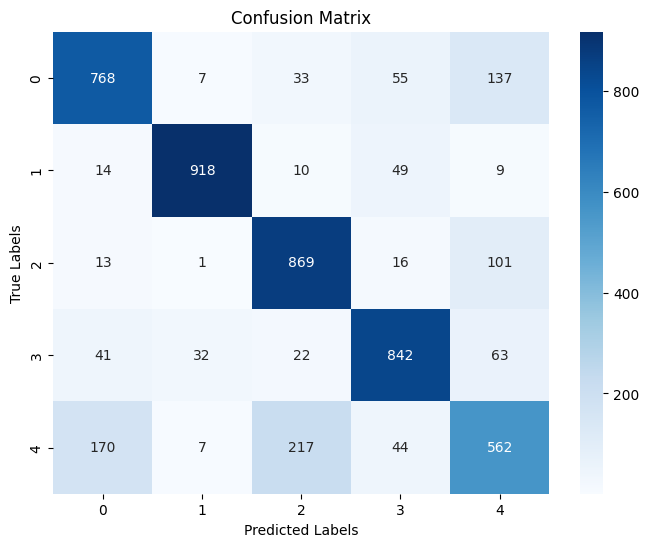

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest, y_predicted)

    # Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming y_test contains true labels and y_pred contains predicted labels
accuracy = accuracy_score(ytest, y_predicted)
precision = precision_score(ytest, y_predicted, average='weighted')  # or 'macro'
recall = recall_score(ytest, y_predicted, average='weighted')        # or 'macro'

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7918
Precision: 0.7902
Recall: 0.7918


### Testing performance of library tree implementation (at different depths)

In [15]:
import random

X = data[:, :-1]  # Features (784 pixel values)
Y = data[:, -1]   # Labels
def k_foldscv(X, y, k, depth):
    seq = [x for x in range(len(X))]
    acc = []
    acc2 = []

    for i in range(k):
        rows = random.sample(seq, int(len(X) / k))

        k_folds_v = X[rows].copy()  # Validation set
        k_folds_t = np.delete(X, rows, axis=0)  # Training set features
        y_folds_t = np.delete(y, rows, axis=0)
        y_folds_v = y[rows]  # Validation set labels

        TREE = DecisionTreeClassifier(max_depth=depth)
        TREE.fit(k_folds_t, y_folds_t)
        prediction = TREE.predict(k_folds_v)
        pred2 = TREE.predict(k_folds_t)
        accuracy = accuracy_score(y_folds_v, prediction)
        ac2 = accuracy_score(y_folds_t, pred2)
        acc.append(accuracy)
        acc2.append(ac2)

    return acc, acc2

train_avgs = []
avgs = []
for depth in range(2, 15):
    accuracy, ac2 = k_foldscv(X, Y, 10, depth)
    avgs.append(accuracy)
    train_avgs.append(ac2)

avgs, train_avgs


([[0.531, 0.51, 0.548, 0.536, 0.553, 0.532, 0.517, 0.532, 0.525, 0.562],
  [0.737, 0.741, 0.744, 0.741, 0.75, 0.743, 0.763, 0.765, 0.76, 0.785],
  [0.758, 0.75, 0.747, 0.782, 0.736, 0.765, 0.755, 0.766, 0.762, 0.757],
  [0.782, 0.781, 0.775, 0.776, 0.769, 0.784, 0.751, 0.8, 0.764, 0.78],
  [0.803, 0.793, 0.786, 0.795, 0.793, 0.797, 0.798, 0.798, 0.799, 0.811],
  [0.805, 0.826, 0.805, 0.782, 0.801, 0.808, 0.813, 0.806, 0.779, 0.816],
  [0.803, 0.828, 0.802, 0.814, 0.807, 0.818, 0.804, 0.795, 0.804, 0.799],
  [0.826, 0.794, 0.78, 0.799, 0.797, 0.795, 0.81, 0.809, 0.812, 0.799],
  [0.806, 0.799, 0.815, 0.81, 0.804, 0.796, 0.793, 0.787, 0.799, 0.813],
  [0.8, 0.82, 0.8, 0.783, 0.786, 0.8, 0.791, 0.809, 0.796, 0.81],
  [0.799, 0.781, 0.773, 0.784, 0.776, 0.788, 0.814, 0.776, 0.791, 0.797],
  [0.811, 0.792, 0.806, 0.803, 0.802, 0.792, 0.794, 0.817, 0.769, 0.786],
  [0.788, 0.806, 0.769, 0.795, 0.799, 0.795, 0.773, 0.788, 0.801, 0.8]],
 [[0.5464444444444444,
   0.5454444444444444,
   0.544333

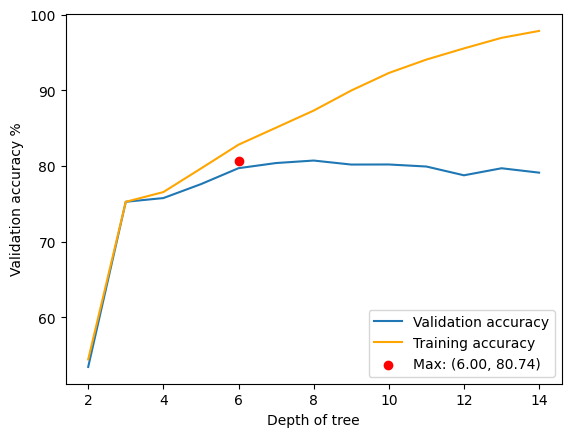

[53.46000000000001, 75.29, 75.77999999999999, 77.62, 79.73, 80.41, 80.74, 80.21000000000001, 80.22, 79.95000000000002, 78.79, 79.71999999999998, 79.14000000000001]


In [16]:
avg_acc = [np.mean(i)*100 for i in avgs]
avg_acc_t = [np.mean(i)*100 for i in train_avgs]
plt.plot(range(2,15), avg_acc, label="Validation accuracy")
plt.plot(range(2,15), avg_acc_t, color="orange", label="Training accuracy")

#plt.title("Validation Accuracy for depths 2-15")
plt.xlabel("Depth of tree")
plt.ylabel("Validation accuracy %")
max_y = np.max(avg_acc)
max_x = 6

plt.scatter(max_x, max_y, color='red', label=f'Max: ({max_x:.2f}, {max_y:.2f})')
plt.legend(loc='lower right')
#plt.ylim((77,84))
plt.show()

print(avg_acc)

**Random forest** (most important feature evaluation):

In [17]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(data[:,:-1], data[:,-1])
imp = rnd_clf.feature_importances_

(-0.5, 27.5, 27.5, -0.5)

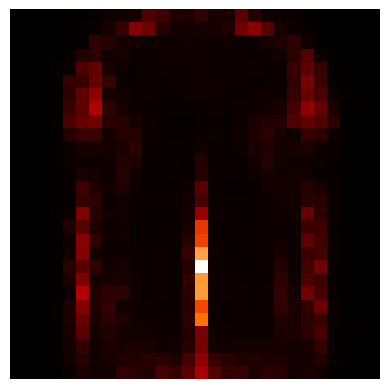

In [18]:
imp = (imp - np.min(imp)) / (np.max(imp) - np.min(imp))
imp = imp.reshape((28,28))

plt.imshow(imp, cmap='gist_heat', vmin=0, vmax=1)
plt.axis('off')

In [19]:
forestpredict = rnd_clf.predict(xtest)
f"{accuracy_score(ytest, forestpredict)*100}% accuracy"

'85.11999999999999% accuracy'

## Testing library tree with varying PC's and depth

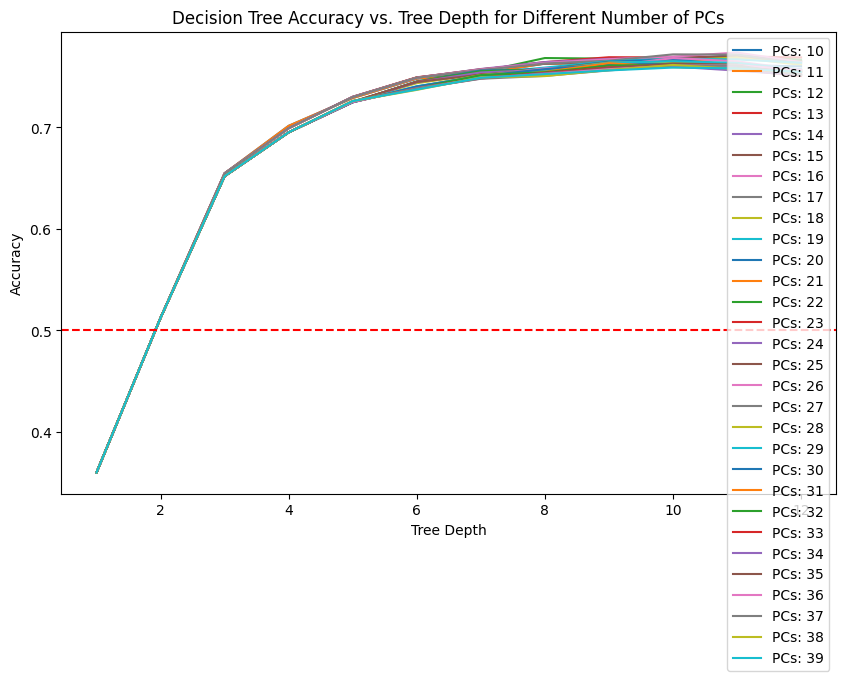

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Prepare your data
X = data[:, :-1]  # Features (784 pixel values)
Y = data[:, -1]   # Labels

X_test = test[:, :-1]
Y_test = test[:, -1]

# Store results for plotting
accuracy_results = []

# Loop over the number of principal components
for n_components in range(10, 40):
    # Step 1: Fit PCA with `n_components`
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X)  # Fit and transform training data
    X_test_pca = pca.transform(X_test)  # Transform test data

    # Store accuracies for each depth
    acc_for_depths = []

    # Loop over the depth of the tree
    for depth in range(1, 13):  # Adjust the range for depth as needed
        tree_clf = DecisionTreeClassifier(max_depth=depth)
        tree_clf.fit(X_train_pca, Y)  # Train the model on PCA-transformed data

        # Make predictions on the PCA-transformed test data
        Y_pred = tree_clf.predict(X_test_pca)

        # Calculate the accuracy of the model
        accuracy = accuracy_score(Y_test, Y_pred)
        acc_for_depths.append(accuracy)

    # Append the accuracies for the current number of components
    accuracy_results.append(acc_for_depths)

# Convert results to a NumPy array for easier indexing
accuracy_results = np.array(accuracy_results)

# Plot the accuracy results for different tree depths for each number of principal components
plt.figure(figsize=(10, 6))
for i in range(accuracy_results.shape[0]):
    plt.plot(range(1, 13), accuracy_results[i], label=f'PCs: {i + 10}')  # +10 to adjust for PC count

plt.axhline(y=0.5, color='red', linestyle='--')  # Example horizontal line at 50% accuracy
plt.title("Decision Tree Accuracy vs. Tree Depth for Different Number of PCs")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()